# Headphone dataset review analysis #

Analyze how customers expressed their feelings about headphones bought through Amazon

Conclusions from explanatory data analysis are provided at the bottom of the notebook. 

Data from: https://www.kaggle.com/datasets/mdwaquarazam/headphone-dataset-review-analysis

---

### ***Imports*** ###

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from wordcloud import WordCloud, ImageColorGenerator

from spacy.lang.en.stop_words import STOP_WORDS
import string
from PIL import Image
from collections import Counter

import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize

In [80]:
# Set of colors to use in plots
plt.style.use('ggplot')
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
%matplotlib inline

### ***General data profiling*** ###

In [4]:
# load data
df = pd.read_csv('inputs/headphone_datn.csv')

In [5]:
# preview data
df.head(5)

,Customer_Name,REVIEW_TITLE,Color,REVIEW_DATE,COMMENTS,RATINGS
0,Ramdika,Really Exceed my expectation.,Black,30-May-21,Okay.. I was skeptical at first to buy this as...,5
1,Sachin AK,Great for a change from inear buds,Black,01-Jun-21,The earphone is worth what you pay for. The de...,5
2,Manikandan Raj,For people with sensitive ears,Black,05-Sep-21,"Particularly for people with sensitive ears, w...",4
3,Reviewguy,I tested it for a week and here's a detailed r...,Iguana,11-Sep-21,Built Quality 6.5 10The lower wire is a durabl...,4
4,Sridhar Sarkar,Not a good headphone,Iguana,26-Jun-21,Don't go with the over all 4 start rating. Thi...,2


In [6]:
df.shape

(1604, 6)

In [7]:
df.isna().sum()

Customer_Name     0
REVIEW_TITLE     10
Color             0
REVIEW_DATE       0
COMMENTS         58
RATINGS           0
dtype: int64

In [8]:
df[df['COMMENTS'].isna() & df['REVIEW_TITLE'].isna()] 

,Customer_Name,REVIEW_TITLE,Color,REVIEW_DATE,COMMENTS,RATINGS
807,janak baldaniya,NaN,Spirit Lime,03-Jan-22,NaN,4
1535,SANTHOSH,NaN,Blue,04-Oct-21,NaN,4


In [9]:
df[df['COMMENTS'].isna()]

,Customer_Name,REVIEW_TITLE,Color,REVIEW_DATE,COMMENTS,RATINGS
345,g.pradeep kumar,Simple and stylish,Black,13-Jun-21,NaN,5
531,chandana,Mic not working after month,White,01-Jan-22,NaN,1
635,Pooja Rane,Good Sound Quality,White,10-Jan-22,NaN,5
716,Amazon Customer,Good,Spirit Lime,09-Dec-21,NaN,5
746,Abhra Kanti Mukherjee,Comfortable and efficient,Iguana,09-Jan-22,NaN,5
807,janak baldaniya,NaN,Spirit Lime,03-Jan-22,NaN,4
828,Unnati,Loved these earphones.,Iguana,08-Nov-21,NaN,5
882,rajesh kumar,Voice cals not working,Blue,17-Nov-21,NaN,1
903,Rony J Gharami,Money valued product at low cost.,Spirit Lime,08-Nov-21,NaN,4
983,Sai Sharvani,Awesome Sound Quality worth buying it .,White,05-May-22,NaN,5


In [10]:
df['Color'].value_counts(normalize=True)

White          0.283042
Black          0.279925
Spirit Lime    0.147132
Blue           0.145885
Iguana         0.144015
Name: Color, dtype: float64

### ***Main classes and functions*** ###

In [11]:
class tiny_preprocessing(object):
    '''
    Simple preprocessing class for text cleanup
    '''
    def __init__(self, text):
        self.text = text
    
    def __getitem__(self, index):
        return self.text[index]
    
    def lower(self):
        self.text = self.text.map(lambda x: str(x).lower())
        return self.text

    def remove_stop_words(self):
        self.text = self.text.map(lambda x: ' '.join([elem for elem in x.split() if elem not in STOP_WORDS]))
        return self.text
    
    def remove_punctuation(self):
        self.text = self.text.map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))
        return self.text

    def simple_preprocess(self):
        self.lower()
        self.remove_stop_words()
        self.remove_punctuation()


In [12]:
def visualize_dict(words_freq, plot_title, color_number = 1):
    plt.title(plot_title)
    plt.barh(*zip(*sorted(words_freq.items(), key = lambda x: x[1])), color = cycle_colors[color_number]);

### ***Text preprocessing*** ###

Comments preprocessing

In [13]:
data = tiny_preprocessing(df['COMMENTS'])
data.simple_preprocess()

data[:]

0       okay skeptical buy tight budget  honest little...
1       earphone worth pay for design earbud cause pai...
2       particularly people sensitive ears gets ear pa...
3       built quality 65 10the lower wire durable nylo...
4       dont 4 start rating boat brand endorse lot mon...
                              ...                        
1599         good sound qualityand impressively good bass
1600                                                  osm
1601    earphones fits ears doesnt block ear outside s...
1602              sound quality bad bad product happy buy
1603             callsmic goodbut comfort bad music worst
Name: COMMENTS, Length: 1604, dtype: object

Review titles preprocessing

In [14]:
data_rev = tiny_preprocessing(df['REVIEW_TITLE'])

In [15]:
data_rev.simple_preprocess()

Tokenize comments

In [16]:
df['comments_prep'] = data[:]
comments_prep_tokens = df['comments_prep'].str.split()

In [17]:
df['review_prep'] = data_rev[:]

Build main corpus

In [18]:
corpus = []
for token in comments_prep_tokens:
    corpus += token

Build single text from comments

In [19]:
text = ' '.join(data[:]) 

### ***Word cloud logo generation*** ###

Clean up the comments column

In [20]:
# change image to numpy array
mask = np.array(Image.open('inputs/headphone-8215.jpg'))

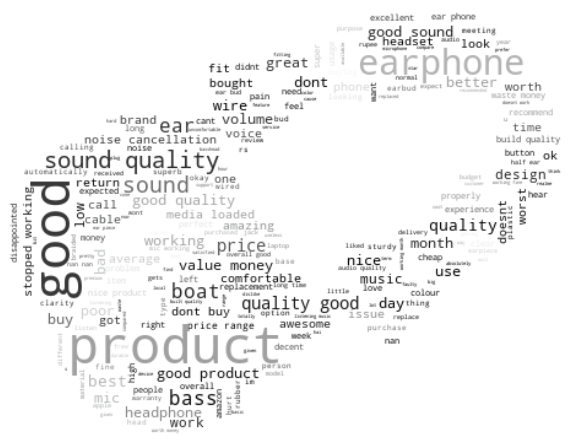

In [21]:
# wordcloud generation
wc = WordCloud(background_color='white', max_words=500, mask = mask, max_font_size=60, random_state=0)
wc.generate(text)

image_colors = ImageColorGenerator(mask)
image_colors.default_color = [0,0,0]

plt.figure(figsize=[10,10])
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off");
plt.savefig('outputs/headphone_word_cloud.png')

### ***Basic statistics for comments*** ###

Statistics done on raw text

Character count

In [22]:
df['char_counts'] = df['COMMENTS'].map(lambda x: len(str(x)))

Word count

In [23]:
df['word_counts'] = df['COMMENTS'].map(lambda x: len(str(x).split()))

Sentence count

In [24]:
df['sent_counts'] = df['COMMENTS'].map(lambda x: len(sent_tokenize(str(x))))

Average word length

In [25]:
df['avg_word_len'] = df["COMMENTS"].map(lambda x: np.mean([len(w) for w in str(x).split()]))

Average sent length

In [26]:
df['avg_sent_len'] = df['COMMENTS'].map(lambda x: np.mean([len(s.split()) for s in sent_tokenize(str(x))]))

### ***Basic statistics for review titles*** ###

Statistics done on raw text

Character count

In [27]:
df['char_counts_rev'] = df['REVIEW_TITLE'].map(lambda x: len(str(x)))

Word count

In [28]:
df['word_counts_rev'] = df['REVIEW_TITLE'].map(lambda x: len(str(x).split()))

Sentence count

In [29]:
df['sent_counts_rev'] = df['REVIEW_TITLE'].map(lambda x: len(sent_tokenize(str(x))))

Average word length

In [30]:
df['avg_word_len_rev'] = df['REVIEW_TITLE'].map(lambda x: np.mean([len(w) for w in str(x).split()]))

Average sent length

In [31]:
df['avg_sent_len_rev'] = df['REVIEW_TITLE'].map(lambda x: np.mean([len(s.split()) for s in sent_tokenize(str(x))]))

### ***Basic statistics for customers*** ###

Is the customer anonymous

In [32]:
df['Customer_Name'].value_counts()

Amazon Customer      86
Rahul                 5
Abhishek              4
Yogesh                3
Ajay                  3
                     ..
sanchita sarkar       1
Jayadevan MK          1
ARUN KUMAR MISHRA     1
Abdulla               1
MohanSiva             1
Name: Customer_Name, Length: 1465, dtype: int64

In [33]:
df['Customer_Name'].nunique()

1465

In [34]:
df['anonymous_customer'] = df['Customer_Name'].map(lambda x: True if x != 'Amazon Customer' else False)

### ***Histograms*** ###

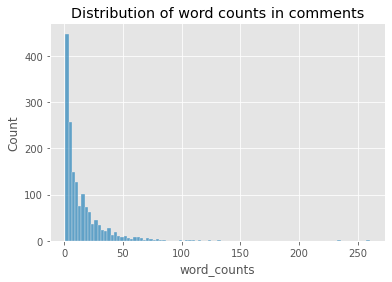

In [35]:
plt.title('Distribution of word counts in comments')
sns.histplot(data = df['word_counts']);

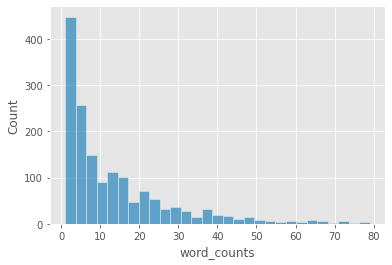

In [36]:
sns.histplot(df[df['word_counts'] < np.percentile(df['word_counts'], 99)]['word_counts']);

In [37]:
np.median(df['word_counts'])

8.0

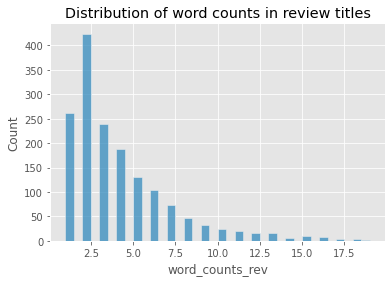

In [38]:
plt.title('Distribution of word counts in review titles')
sns.histplot(data = df['word_counts_rev']);

In [39]:
np.median(df['word_counts_rev'])

3.0

In [40]:
df['word_counts_rev'].max()

19

In [41]:
np.median(df[df['COMMENTS'].isna()]['word_counts_rev'])

5.0

c:\Users\mariu\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


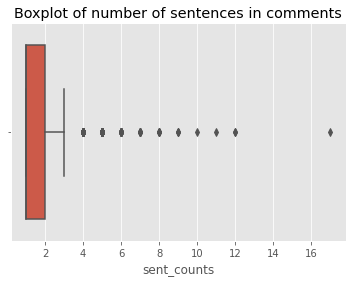

In [42]:
plt.title('Boxplot of number of sentences in comments')
sns.boxplot(df['sent_counts']);

In [43]:
df['sent_counts'].describe()

count    1604.000000
mean        1.593516
std         1.336883
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        17.000000
Name: sent_counts, dtype: float64

---

### ***General Term Frequency Analysis*** ###

Show most common words

In [44]:
most_common_words = nltk.FreqDist(corpus).most_common(10)
most_common_words

[('good', 673),
 ('quality', 543),
 ('sound', 467),
 ('product', 414),
 ('bass', 166),
 ('ear', 151),
 ('working', 151),
 ('boat', 149),
 ('price', 145),
 ('earphones', 140)]

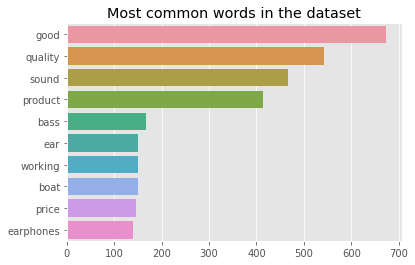

In [45]:
plt.title('Most common words in the dataset')
sns.barplot(x = [elem[1] for elem in most_common_words], y = [elem[0] for elem in most_common_words]);

In [46]:
print(f'Word count of the word "very": {nltk.FreqDist(corpus)["very"]}')
print(f'Word count of the word "not": {nltk.FreqDist(corpus)["not"]}')

Word count of the word "very": 1
Word count of the word "not": 2


### ***Sentiment based term Frequency Analysis*** ###

Sentiment construction based an ratings

In [47]:
sentiment_dict = {'positive': [5, 4], 'neutral': [3], 'negative': [1, 2]}

def key_return(x):
    return next(k for k,v in sentiment_dict.items() if x in v)

df['RATINGS_SENTIMENT'] = df['RATINGS'].map(lambda x: key_return(x))

In [77]:
df['RATINGS_SENTIMENT'].value_counts(normalize = True)

positive    0.581671
negative    0.324190
neutral     0.094140
Name: RATINGS_SENTIMENT, dtype: float64

Positive comments

In [49]:
positive_tokens = df[df['RATINGS_SENTIMENT'] == 'positive']['comments_prep'].str.split()
positive_corpus = []
for token in positive_tokens:
    positive_corpus += token

In [50]:
most_common_words_positive = nltk.FreqDist(positive_corpus).most_common(10)

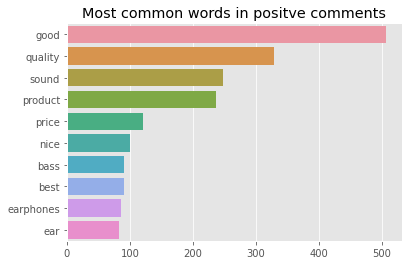

In [51]:
plt.title('Most common words in positve comments')
sns.barplot(x = [elem[1] for elem in most_common_words_positive], y = [elem[0] for elem in most_common_words_positive]);

Negative comments

In [52]:
negative_tokens = df[df['RATINGS_SENTIMENT'] == 'negative']['comments_prep'].str.split()
negative_corpus = []
for token in negative_tokens:
    negative_corpus += token

In [53]:
most_common_words_negative = nltk.FreqDist(negative_corpus).most_common(10)

In [54]:
most_common_words_negative

[('sound', 162),
 ('quality', 160),
 ('product', 153),
 ('working', 117),
 ('good', 89),
 ('boat', 73),
 ('buy', 65),
 ('dont', 60),
 ('ear', 53),
 ('poor', 52)]

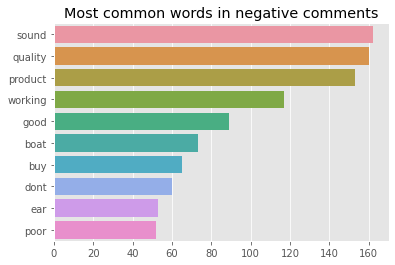

In [55]:
plt.title('Most common words in negative comments')
sns.barplot(x = [elem[1] for elem in most_common_words_negative], y = [elem[0] for elem in most_common_words_negative]);

---

🔵`Conclusion 1`🔵

Top single tokens for positive and negative reviews are in most cases the same and don't provide any meaningful insight.

---

### ***N-grams Frequency Analysis*** ###

All tokens

In [56]:
from sklearn.feature_extraction.text import CountVectorizer

In [57]:
vec = CountVectorizer(ngram_range=(2,2))
bow = vec.fit_transform(df['comments_prep'])

In [58]:
count_values = bow.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in vec.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

In [59]:
ngram_freq

,frequency,ngram
0,217,sound quality
1,103,quality good
2,75,good product
3,68,value money
4,66,good quality
...,...,...
8261,1,10 couple
8262,1,10 built
8263,1,10 better
8264,1,10 audio


In [60]:
n_grams = nltk.FreqDist(list(nltk.ngrams(corpus, 2)))
n_grams

FreqDist({('sound', 'quality'): 218, ('quality', 'good'): 109, ('good', 'product'): 77, ('value', 'money'): 68, ('good', 'quality'): 68, ('good', 'sound'): 66, ('product', 'good'): 44, ('noise', 'cancellation'): 44, ('stopped', 'working'): 39, ('dont', 'buy'): 39, ...})

In [61]:
most_common_n_grams = n_grams.most_common(10)
bi_grams_dict_keys = [elem[0][0] + ' ' + elem[0][1] for elem in most_common_n_grams]
bi_grams_dict_vals = [elem[1] for elem in most_common_n_grams]
bi_grams_dict = dict(zip(bi_grams_dict_keys, bi_grams_dict_vals))
bi_grams_dict

{'sound quality': 218,
 'quality good': 109,
 'good product': 77,
 'value money': 68,
 'good quality': 68,
 'good sound': 66,
 'product good': 44,
 'noise cancellation': 44,
 'stopped working': 39,
 'dont buy': 39}

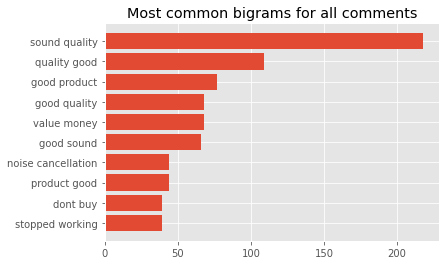

In [62]:
plt.title('Most common bigrams for all comments')
plt.barh(*zip(*sorted(bi_grams_dict.items(), key = lambda x: x[1])));

Only positive reviews

In [63]:
n_grams = nltk.FreqDist(list(nltk.ngrams(positive_corpus, 2)))
n_grams

FreqDist({('sound', 'quality'): 134, ('quality', 'good'): 73, ('good', 'quality'): 63, ('good', 'product'): 60, ('value', 'money'): 58, ('good', 'sound'): 50, ('product', 'good'): 44, ('noise', 'cancellation'): 29, ('nice', 'product'): 27, ('good', 'good'): 26, ...})

In [64]:
most_common_n_grams = n_grams.most_common(10)
bi_grams_dict_keys = [elem[0][0] + ' ' + elem[0][1] for elem in most_common_n_grams]
bi_grams_dict_vals = [elem[1] for elem in most_common_n_grams]
bi_grams_dict = dict(zip(bi_grams_dict_keys, bi_grams_dict_vals))
bi_grams_dict

{'sound quality': 134,
 'quality good': 73,
 'good quality': 63,
 'good product': 60,
 'value money': 58,
 'good sound': 50,
 'product good': 44,
 'noise cancellation': 29,
 'nice product': 27,
 'good good': 26}

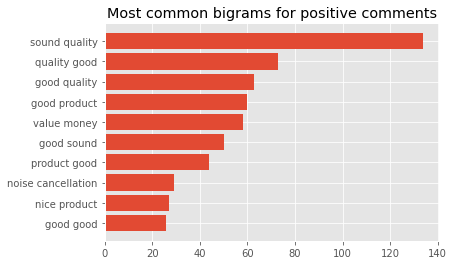

In [65]:
plt.title('Most common bigrams for positive comments')
plt.barh(*zip(*sorted(bi_grams_dict.items(), key = lambda x: x[1])));

Only negative comments

In [66]:
n_grams = nltk.FreqDist(list(nltk.ngrams(negative_corpus, 2)))
n_grams

FreqDist({('sound', 'quality'): 59, ('stopped', 'working'): 37, ('dont', 'buy'): 34, ('quality', 'good'): 24, ('waste', 'money'): 23, ('2', 'months'): 15, ('poor', 'quality'): 14, ('buy', 'product'): 11, ('quality', 'poor'): 11, ('media', 'loaded'): 11, ...})

In [67]:
most_common_n_grams = n_grams.most_common(10)
bi_grams_dict_keys = [elem[0][0] + ' ' + elem[0][1] for elem in most_common_n_grams]
bi_grams_dict_vals = [elem[1] for elem in most_common_n_grams]
bi_grams_dict = dict(zip(bi_grams_dict_keys, bi_grams_dict_vals))
bi_grams_dict

{'sound quality': 59,
 'stopped working': 37,
 'dont buy': 34,
 'quality good': 24,
 'waste money': 23,
 '2 months': 15,
 'poor quality': 14,
 'buy product': 11,
 'quality poor': 11,
 'media loaded': 11}

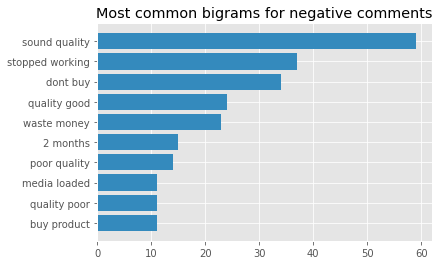

In [68]:
visualize_dict(bi_grams_dict, 'Most common bigrams for negative comments',1)

### ***Parts of Speech*** ###

In [69]:
def return_pos(corpus: list, tag_name: str, n_most_common: int = 10) -> list:
    tags = nltk.pos_tag(corpus, tagset = 'universal')
    tags = [word for word, tag in tags if tag == tag_name]

    most_common = Counter(tags).most_common(n_most_common)
    return dict(zip([elem[0] for elem in most_common], [elem[1] for elem in most_common]))

In [70]:
general_corpus_adjevtives = return_pos(corpus, 'ADJ')
general_corpus_adjevtives

{'good': 665,
 'sound': 146,
 'nice': 104,
 'mic': 77,
 'best': 69,
 'great': 69,
 'ear': 66,
 'poor': 56,
 'bad': 53,
 'low': 44}

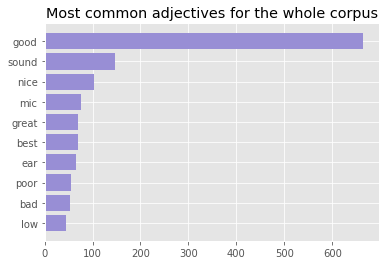

In [71]:
visualize_dict(general_corpus_adjevtives, 'Most common adjectives for the whole corpus', 2)

In [72]:
positive_comments_adjevtives = return_pos(positive_corpus, 'ADJ')
positive_comments_adjevtives

{'good': 503,
 'nice': 90,
 'sound': 67,
 'best': 61,
 'great': 56,
 'ear': 36,
 'comfortable': 36,
 'mic': 30,
 'long': 26,
 'overall': 26}

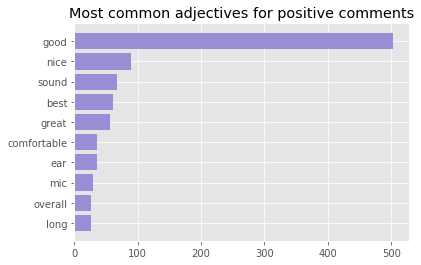

In [73]:
visualize_dict(positive_comments_adjevtives, 'Most common adjectives for positive comments', 2)

In [74]:
negative_comments_adjevtives = return_pos(negative_corpus, 'ADJ')
negative_comments_adjevtives

{'good': 86,
 'sound': 61,
 'poor': 52,
 'bad': 40,
 'mic': 36,
 'worst': 28,
 'ear': 25,
 'low': 23,
 'dont': 16,
 'cant': 16}

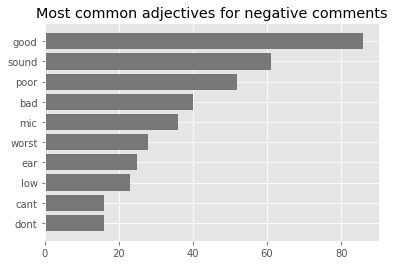

In [75]:
visualize_dict(negative_comments_adjevtives, 'Most common adjectives for negative comments', 3)

In [76]:
some_complex_name

NameError: name 'some_complex_name' is not defined